### **BASE DE DATOS: GOOG-year**
**Este código consiste en un script de Python que emplea TensorFlow para crear un modelo de predicción utilizando una red neuronal recurrente (RNN) LSTM (Long Short-Term Memory) con el propósito de anticipar la dirección en la que se moverán los precios de cierre de una acción.**

**1.** *El código comienza importando las bibliotecas necesarias y configurando opciones para suprimir advertencias. Luego, importa bibliotecas como TensorFlow, NumPy, Matplotlib y Pandas para el análisis y procesamiento de datos.*

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

Se carga la data desde un archivo CSV que contiene información sobre los precios de cierre de una acción (Google).

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

# Establece una semilla para TensorFlow para obtener resultados reproducibles
tf.random.set_seed(1234)

# Carga los datos
df = pd.read_csv('GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-10,99.849998,99.989998,97.870003,98.709999,98.709999,16529900
1,2022-10-11,98.250000,100.120003,97.250000,98.050003,98.050003,21617700
2,2022-10-12,98.269997,99.648003,97.669998,98.300003,98.300003,17343400
3,2022-10-13,95.930000,100.529999,95.269997,99.709999,99.709999,32812200
4,2022-10-14,100.625000,101.290001,97.029999,97.180000,97.180000,22624800


**2.**  Luego, los datos se normalizan utilizando Min-Max Scaling para escalar los valores de los precios de cierre en un rango entre 0 y 1.

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.271737
1,0.259954
2,0.264417
3,0.289591
4,0.244421


**3.** El conjunto de datos se divide en dos partes: un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento incluye los datos desde el inicio hasta los últimos 30 días, mientras que el conjunto de prueba abarca los últimos 30 días.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape


((252, 7), (222, 1), (30, 1))

**4**.Se define una clase llamada "Modelo" que representa la arquitectura de una red neuronal LSTM. El modelo se configura con hiperparámetros como la tasa de aprendizaje, el número de capas LSTM, el tamaño de las capas y otros.

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


### Configuración de **hiperparámetros** del modelo


In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

### **Función para realizar pronósticos**


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tqdm import tqdm

def forecast():
    model = Sequential()
    model.add(LSTM(size_layer, input_shape=(timestamp, df_log.shape[1]), return_sequences=True))
    model.add(LSTM(size_layer, return_sequences=True))
    model.add(Dense(df_log.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
          index = min(k + timestamp, df_train.shape[0] - 1)
          batch_x = np.zeros((1, 5, 1))
          batch_x[0, :index - k, 0] = df_train.iloc[k : index, :].values.reshape(-1)
          batch_y = np.zeros((1, 5, 1))
          batch_y[0, :index - k, 0] = df_train.iloc[k + 1 : index + 1, :].values.reshape(-1)
          loss = model.train_on_batch(batch_x, batch_y)
          total_loss.append(loss)
          pbar.set_postfix(cost=np.mean(total_loss))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0].values
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = model.predict(df_train.iloc[k : k + timestamp, :].values.reshape(1, timestamp, -1))
        output_predict[k + 1 : k + timestamp + 1] = out_logits[0]

    if upper_b != df_train.shape[0]:
        out_logits = model.predict(df_train.iloc[upper_b:, :].values.reshape(1, df_train.shape[0] - upper_b, -1))
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits[0]
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = out_logits[0]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = model.predict(o.reshape(1, timestamp, -1))
        # Almacena solo la última predicción en la posición adecuada
        output_predict[-future_day + i, 0] = out_logits[0, -1, 0]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [04:26<00:00,  1.13it/s, cost=0.00188]


1/1 [==============================] - 0s 20ms/step
simulation 2


train loop: 100%|██████████| 300/300 [04:38<00:00,  1.08it/s, cost=0.00188]


1/1 [==============================] - 0s 25ms/step
simulation 3


train loop: 100%|██████████| 300/300 [04:43<00:00,  1.06it/s, cost=0.00188]


1/1 [==============================] - 0s 34ms/step
simulation 4


train loop: 100%|██████████| 300/300 [04:35<00:00,  1.09it/s, cost=0.00188]


1/1 [==============================] - 0s 24ms/step
simulation 5


train loop: 100%|██████████| 300/300 [04:47<00:00,  1.04it/s, cost=0.00188]


1/1 [==============================] - 0s 22ms/step
simulation 6


train loop: 100%|██████████| 300/300 [05:07<00:00,  1.02s/it, cost=0.00189]


1/1 [==============================] - 0s 22ms/step
simulation 7


train loop: 100%|██████████| 300/300 [04:58<00:00,  1.01it/s, cost=0.0019]


1/1 [==============================] - 0s 21ms/step
simulation 8


train loop: 100%|██████████| 300/300 [05:00<00:00,  1.00s/it, cost=0.00191]


1/1 [==============================] - 0s 26ms/step
simulation 9


train loop: 100%|██████████| 300/300 [04:54<00:00,  1.02it/s, cost=0.00193]


1/1 [==============================] - 0s 28ms/step
simulation 10


train loop: 100%|██████████| 300/300 [05:05<00:00,  1.02s/it, cost=0.00188]


1/1 [==============================] - 0s 21ms/step


### **Cálculo de la precisión de los pronósticos y visualización de los resultados**

Las simulaciones se visualizan en un gráfico que muestra los pronósticos en comparación con la verdadera tendencia de los precios de cierre.

El código implementa un modelo de aprendizaje automático basado en redes neuronales LSTM para pronosticar los precios de cierre de una acción financiera. El modelo se entrena en datos históricos y se evalúa su precisión en un conjunto de prueba. Las simulaciones múltiples se realizan para evaluar la estabilidad del modelo y se muestran los resultados en un gráfico.

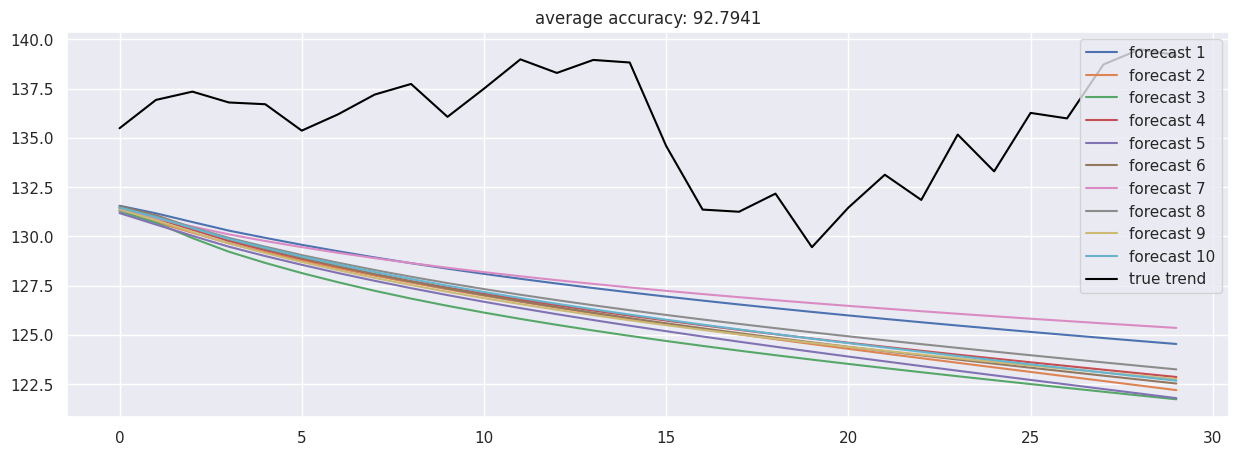

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()